In [33]:
from transformers import T5Tokenizer, MT5ForConditionalGeneration

**Загрузка токенизатора**

In [34]:
tokenizer = T5Tokenizer.from_pretrained(
    "kavlab/review-t5",
    revision="1.0.0"
)

**Загрузка модели**

In [35]:
model = MT5ForConditionalGeneration.from_pretrained(
    "kavlab/review-t5",
    revision="1.0.0"
)

**Выбираем отзывы для проверки на корректность**

In [36]:
import pandas as pd
import ast

In [37]:
# Загружаем очищенный и подготовленный датасет
data = pd.read_csv(
    "./kw_cleared_dataset.csv",
    sep=";",
    encoding='utf-8-sig',
    index_col=0
)
data["rubrics_list"] = data["rubrics_list"].apply(ast.literal_eval)
data["key_words"] = data["key_words"].apply(ast.literal_eval)
data.columns = ["rating", "rubrics_list", "text", "key_words"]

In [38]:
N = 100

sample = data.sample(N, random_state=42)

test_list = []
for v in sample[["rubrics_list", "key_words", "rating"]].values:
    test = {
        "rubrics": v[0],
        "keywords": v[1],
        "rating": v[2],
    }
    test_list.append(test)

In [39]:
def make_query(row):
    query = (
        f"<rubrics>: {', '.join(row['rubrics_list'])} | "
        f"<raiting>: {row['rating']} | "
        f"<keywords>: {', '.join(row['key_words'])}"
    )
    return query

In [40]:
max_target_length = 512

for random_value in test_list:

    params = {
        "rubrics_list": random_value["rubrics"],
        "rating": random_value["rating"],
        "key_words": random_value["keywords"],
    }
    query = make_query(params)

    input_ids = tokenizer(query, return_tensors="pt").input_ids

    outputs = model.generate(
        input_ids,
        max_length=max_target_length,
        do_sample=True,
        temperature=0.8,
        repetition_penalty=1.4,
        num_beams=4,
        top_k=30,
        top_p=0.9,
    )

    print(query)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))
    print()

<rubrics>: информационный интернет сайт, агентство недвижимости | <raiting>: 5 | <keywords>: тюмень, облачные сервисы
Отличный сервис, всегда помогут и подскажут. Обращаюсь в Тюмень уже не первый раз, и ни разу не пожалел, что выбрал именно эту компанию.

<rubrics>: гостиница | <raiting>: 5 | <keywords>: релокейт
Отличный отель. Вежливый и отзывчивый персонал. Номера чистые и уютные. Завтрак шведский стол очень вкусно и разнообразно.

<rubrics>: зоосалон, зоопарикмахерская, зоомагазин | <raiting>: 5 | <keywords>: грумер анна, гаджеты, здоровье
Замечательный салон, вежливый персонал, приятная атмосфера, всегда чисто и уютно. Особенно хочется отметить грумер Анну, которая очень аккуратно и бережно относится к питомцам.

<rubrics>: спортивный магазин, спортивная одежда и обувь, товары для отдыха и туризма | <raiting>: 1 | <keywords>: управление персоналом
Ужасный персонал, грубо разговаривают, хамят. Не советую посещать данный магазин.

<rubrics>: магазин чая, магазин посуды | <raiting>: 

**Оценка качества модели с помощью «классического» расчета доверительного интервала**

Для расчета интервальной оценки (доверительного интервала) модели генерации отзывов можно использовать различные методы статистики. В данном случае метрикой модели будет являться доля корректных отзывов. Ниже представлены формулы данного расчета.

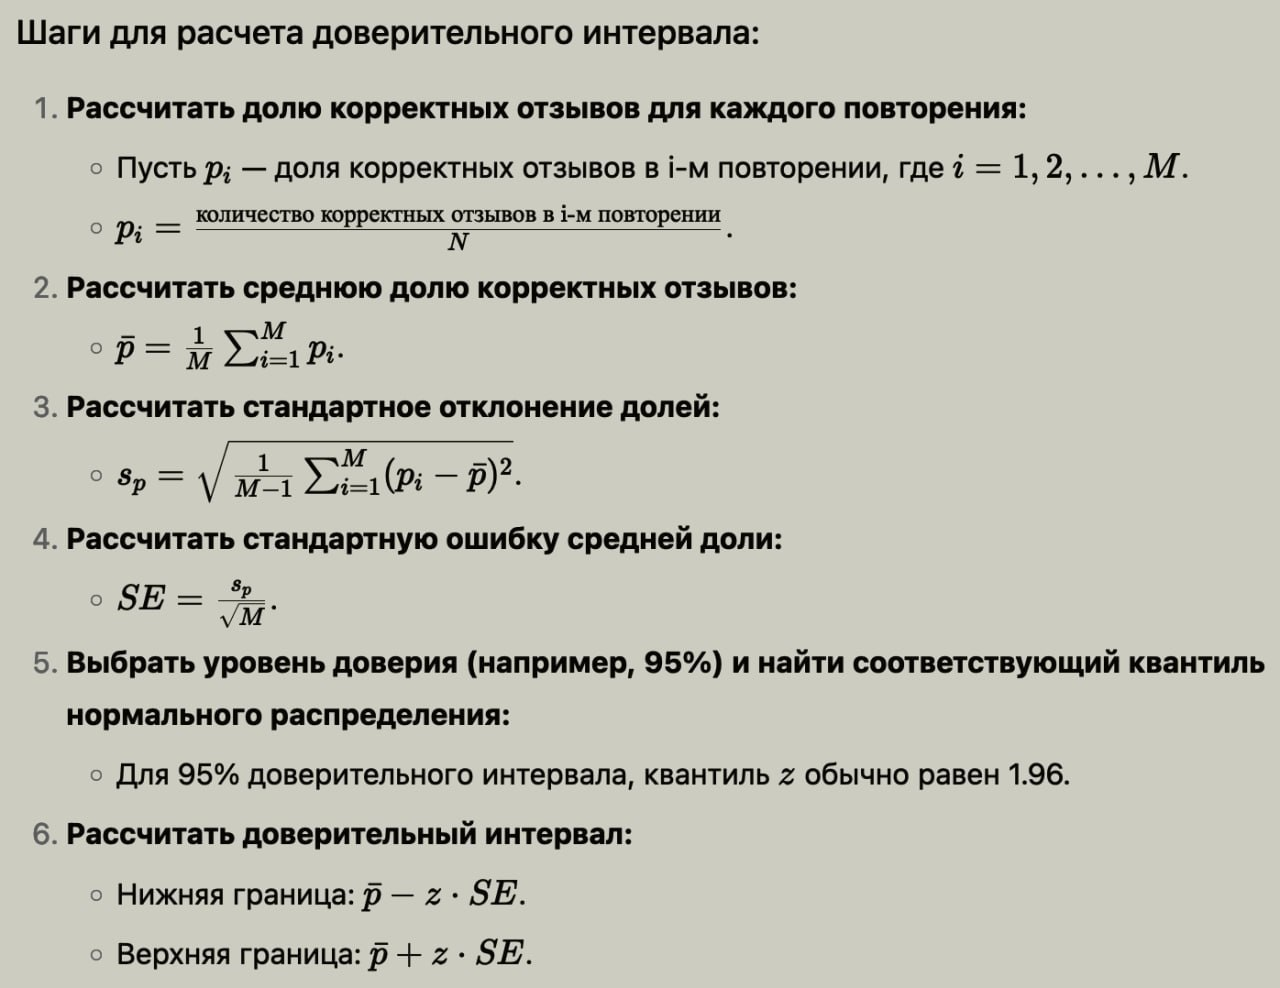

**Расчет корректных отзывов для выборки отзывов об объектах.**

Отзывы считаются некорректными в следующем случае:
1. В отзыве не упоминается каким-либо образом рубрика или объект, и соответственно он может применим к другим рубрикам;
2. Если отзыв положительный, а рейтинг объекта низкий;
3. Если отзыв отрицательный, а рейтинг объекта высокий;
4. Текст отзыва логически не связан сам «собой» (набор не связанных в логическую «цепь» слов).

Рассчитаем долю корректных отзывов для объектов полученных с помощью 5 итераций (см. файл с отзывами - "Reviews.htm"):

In [41]:
p1=(19)/20
p2=(20)/20
p3=(19)/20
p4=(19)/20
p5=(20)/20

print ("Доля корректных отзывов для объектов имеющих разный рейтинг:")
print ("p1 =",p1)
print ("p2 =",p2)
print ("p3 =",p3)
print ("p4 =",p4)
print ("p5 =",p5)

print ("Средняя доля корректных отзывов:")
p=(p1+p2+p3+p4+p5)/5
print ("p =",p)

Доля корректных отзывов для объектов имеющих разный рейтинг:
p1 = 0.95
p2 = 1.0
p3 = 0.95
p4 = 0.95
p5 = 1.0
Средняя доля корректных отзывов:
p = 0.97


Расчитаем стандартное отклонение долей:

In [42]:
Sp=(((p1-p)**2+(p2-p)**2+(p3-p)**2+(p4-p)**2+(p5-p)**2)/4)**0.5
print ("Sp =",Sp)

Sp = 0.02738612787525833


Рассчитаем стандартную ошибку средней доли:

In [43]:
SE=Sp/(5**0.5)
print ("SE =",SE)

SE = 0.012247448713915901


Выбираем уровень доверия 95%, которому соответствует квантиль нормального распределения 1.96

In [44]:
z=1.96

Рассчитаем нижнюю и верхнюю границу доверительного интервала:

In [45]:
print ("Нижняя граница доверительного интервала:",p-z*SE)
print ("Верхняя граница доверительного интервала:",p+z*SE)

Нижняя граница доверительного интервала: 0.9459950005207248
Верхняя граница доверительного интервала: 0.9940049994792751


Оценка качества модели с помощью расчета биномиального доверительного интервала (метод «wilson»)

In [46]:
from scipy.stats import binomtest

result = binomtest(k=(19+20+19+19+20), n=100)

result.proportion_ci(confidence_level=0.95, method="wilson")

ConfidenceInterval(low=0.9154806357094724, high=0.9897454759759611)

In [47]:
print ("Средняя доля корректных отзывов:", result.statistic)
print ("Нижняя граница доверительного интервала:", "0.9154806357094724")
print ("Верхняя граница доверительного интервала:", "0.9897454759759611")

Средняя доля корректных отзывов: 0.97
Нижняя граница доверительного интервала: 0.9154806357094724
Верхняя граница доверительного интервала: 0.9897454759759611


**Вывод:**

Для оценки качества работы модели использовалось 100 отзывов, сгенерированных ей (5 итераций по 20 отзывов), отзывы выбирались случайно из общего количества. Оценка осуществлялась с помощью математических методов статистики двумя разными способами.
Средняя доля, нижняя и верхняя граница доверительного интервала практически совпала при расчетах двумя разными способами. Расчетные значения показывают, отличное качество обученной модели. На мой взгляд, единственным недостатком этих расчетов является необходимость применения “ручной” работы, корректность отзывов приходиться самому человеку определять.
